In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [4]:
trains = sorted(data['train'].unique().tolist())
len(trains)

112

In [5]:
maxdays = 30

In [6]:
models = {}
metrics = []

for train in tqdm(trains):
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel(maxiter=100000)
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.head()

  0%|          | 0/112 [00:00<?, ?it/s]

,num,class,explained,r2,train
0,001А,Купе,0.789427,0.177405,001А-Купе
1,002А,Купе,0.823380,0.206602,002А-Купе
2,005А,СВ,0.847117,0.169174,005А-СВ
3,006А,СВ,0.876931,0.177509,006А-СВ
4,701Н,СВ,0.665765,0.624373,701Н-СВ


In [7]:
a = pd.DataFrame({train: model.a for train, model in models.items()})

a.head(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,702Н-СВ,702Н-Сидячий,703Н-СВ,703Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,0.272274,0.980876,0.381817,1.793806,NaN,NaN,NaN,0.195136,NaN,NaN,...,-0.075720,0.469554,0.487015,1.394646,0.525794,0.745639,-0.106855,0.797818,0.431548,0.93316
2021-04-13,0.231674,0.970764,1.083278,1.470325,NaN,0.329414,-0.427934,0.336932,0.960127,0.90381,...,-1.325353,-0.334608,0.464369,1.642654,0.801214,1.138874,-0.090908,0.201627,-0.121707,0.67748


In [8]:
df = {}

for train in a.columns:
    ts = a[train].copy()
    assert abs(ts.mean()) < 1e-8
    ts /= ts.std()
    
    ts.index = ts.index.day_name()
    
    df[train] = ts.groupby(level=0).mean()
    
df = pd.DataFrame(df).reindex(weekdays.values())

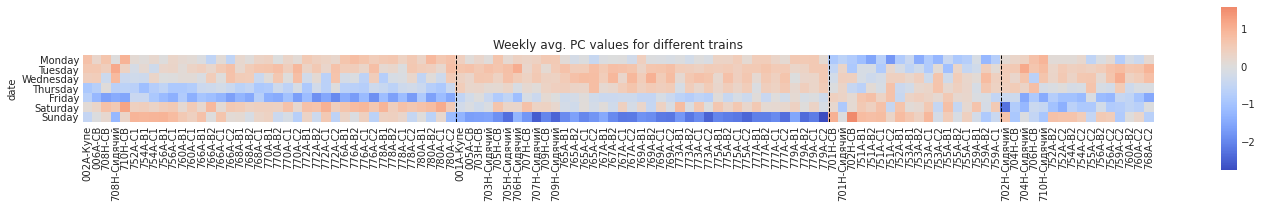

In [9]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=6, n_init=50)
clusters = pd.Series(kmeans.fit_predict(df.values.T), index=df.columns, name='cluster')

clusters = clusters.reset_index().sort_values(by=['cluster', 'index']).set_index('index')['cluster']

df = df[clusters.index]

plt.figure(figsize=(24, 3))

sns.heatmap(df, square=True, xticklabels=True, cmap='coolwarm', center=0, cbar_kws={'aspect': 10})

for n in clusters.value_counts().sort_index().cumsum():
    plt.axvline(n, lw=1, c='k', ls='dashed')

plt.title('Weekly avg. PC values for different trains')
plt.savefig('../data/figures/weekly_avg_pcs.pdf', transparent=True, bbox_inches='tight')

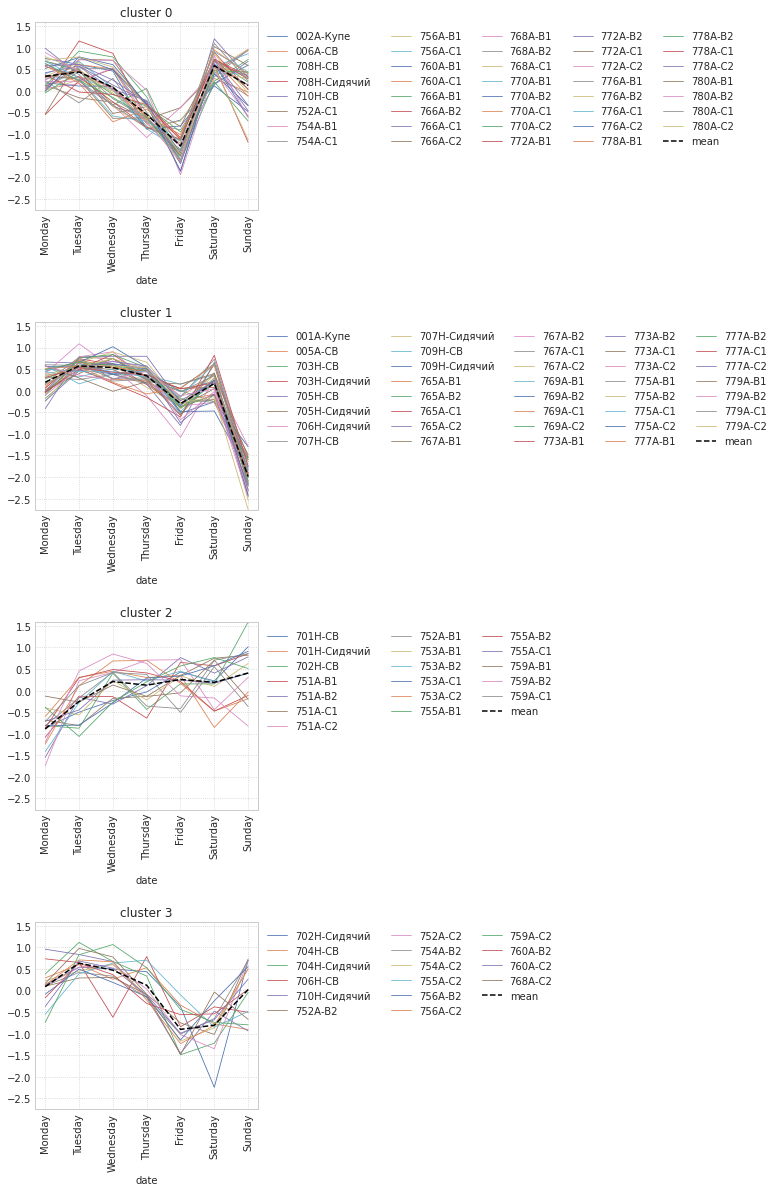

In [10]:
nrows = k

fig, axes = plt.subplots(nrows=nrows)
fig.set_size_inches(4, 5 * nrows)
fig.subplots_adjust(hspace=0.6)

vmin = df.min().min()
vmax = df.max().max()

for cluster, ax in zip(np.unique(clusters), axes):
    df_ = df.T[clusters == cluster]
    
    df_.T.plot(ax=ax, lw=0.8)
    
    df_.mean().plot(ax=ax, c='k', ls='dashed', label='mean')

    ax.legend().set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=df_.shape[0] // 8 + 1)
    ax.set_ylim(vmin, vmax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(f'cluster {cluster}')
    
plt.savefig('../data/figures/weekly_avg_pc_clusters.pdf', transparent=True, bbox_inches='tight')

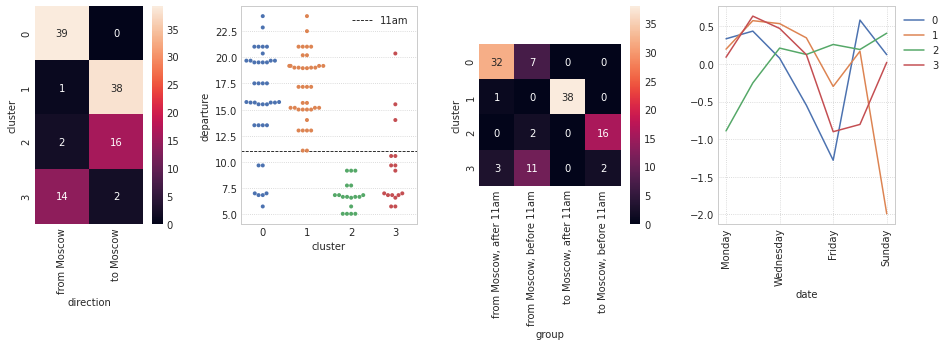

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)
fig.subplots_adjust(wspace=0.35)

train_properties = pd.DataFrame(index=df.columns)
train_properties.index.name = 'train'

train_properties['cluster'] = clusters

train_properties['direction'] = train_properties.index.map(
    lambda s: 'from Moscow' if int(s.split('-')[0][:-1]) % 2 == 0 else 'to Moscow')

sns.heatmap(pd.crosstab(train_properties['cluster'], train_properties['direction']), ax=ax1, square=True, annot=True)

train_properties['departure'] = data.drop_duplicates('train')\
    .set_index('train')[['departure_timestamp']]

th = 11

train_properties['departs'] = train_properties['departure'].apply(
    lambda h: f'before {th}am' if h <= th else f'after {th}am')

sns.swarmplot(data=train_properties, x='cluster', y='departure', size=4, ax=ax2)
ax2.axhline(th, c='k', ls='dashed', lw=0.8, label=f'{th}am')
ax2.legend()

train_properties['group'] = train_properties['direction'] + ', ' + train_properties['departs']

sns.heatmap(pd.crosstab(train_properties['cluster'], train_properties['group']), ax=ax3, square=True, annot=True)

grp = df.copy().T
grp['cluster'] = clusters

grp = grp.groupby('cluster').mean()

#ax4.plot(grp.T)
grp.T.plot(ax=ax4)
ax4.tick_params(axis='x', rotation=90)
ax4.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('../data/figures/explaining_weekly_avg_pc_clusters.pdf', transparent=True, bbox_inches='tight')

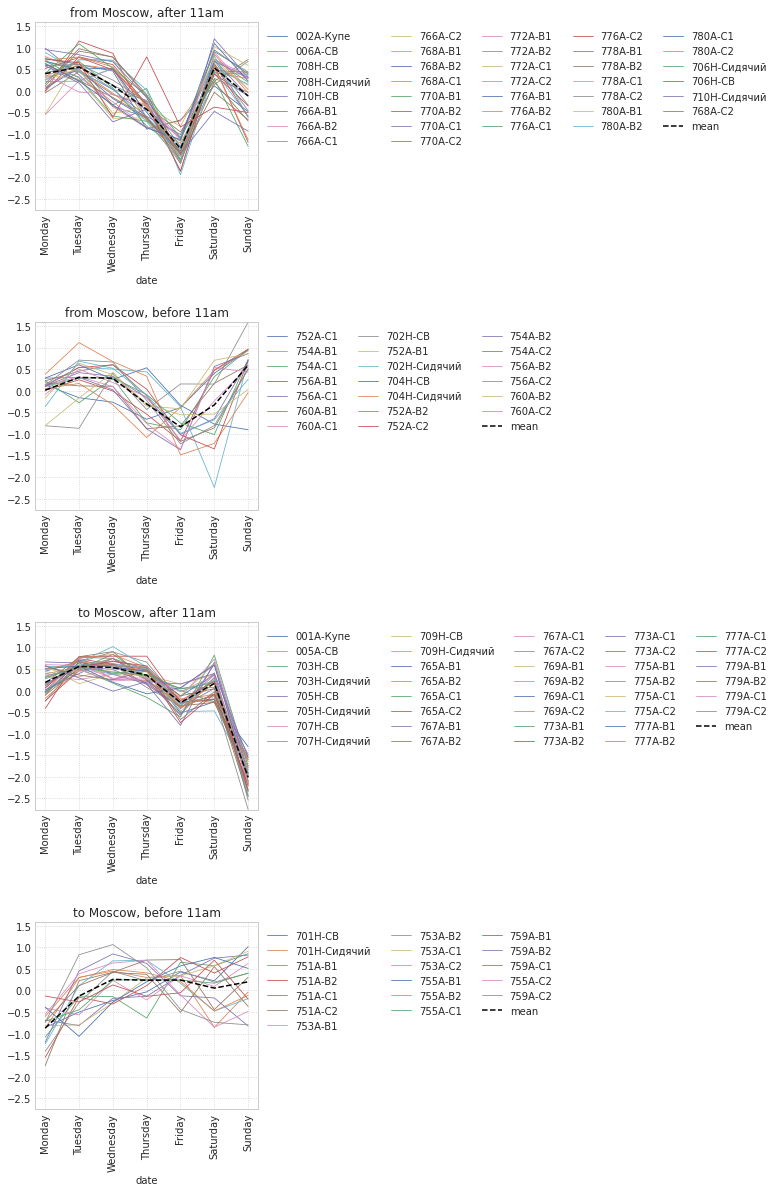

In [13]:
nrows = k

fig, axes = plt.subplots(nrows=nrows)
fig.set_size_inches(4, 5 * nrows)
fig.subplots_adjust(hspace=0.6)

vmin = df.min().min()
vmax = df.max().max()

for cluster, ax in zip(np.unique(train_properties['group']), axes):
    df_ = df.T[train_properties['group'] == cluster]
    
    df_.T.plot(ax=ax, lw=0.8)
    
    df_.mean().plot(ax=ax, c='k', ls='dashed', label='mean')

    ax.legend().set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=df_.shape[0] // 8 + 1)
    ax.set_ylim(vmin, vmax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(cluster)
    
plt.savefig('../data/figures/weekly_avg_pc_groups.pdf', transparent=True, bbox_inches='tight')

In [14]:
train_properties.to_csv('../data/weekly_avg_pc_clusters.csv', index=False)

In [15]:
!jupyter nbconvert --to html 2_weekends.ipynb

[NbConvertApp] Converting notebook 2_weekends.ipynb to html
[NbConvertApp] Writing 603297 bytes to 2_weekends.html
